# Hyperwave: ETL pipeline

First, let's import all the libraries needed for our ETL pipeline (extract-transform-load).

In [26]:
import os
import scipy.io
import numpy as np
import xarray as xr
import xrft

Let's configure our I/O directories, as well as some runtime processing options.

In [27]:
# I/O configuration
input_folder = '../data/mat'
output_folder = '../data/ncdf'

# Runtime configuration
os.makedirs(output_folder, exist_ok=True)
np.set_printoptions(suppress=True, precision=20)

dataset = [] # The dataset variable will contain our polished dataset

The temporal axis contains 5401 timesteps, collected across a linear surface capturing 100 datapoints for each timestep. In order to obtain a 1D vector for each central frequency, we can squash the 100 datapoints into just one using a Gaussian weighting, which is a natural choice in this setting. The function below, **gaussian_squashing()**, is an implementation of such weighting.

In [28]:
def gaussian_squashing(signal, squash_axis=0, iter_axis=1):
    # Define gaussian squashing parameters
    timesteps = np.arange(np.shape(signal)[iter_axis])
    indices = np.arange(np.shape(signal)[squash_axis])
    center = len(indices) / 2 # gaussian mean index
    sigma = len(indices) / 10  # smaller → narrower peak
    squashed_signal = []
    for t in timesteps:
        # Compute Gaussian weights
        weights = np.exp(-0.5 * ((indices - center) / sigma) ** 2)
        # Normalize weights so they sum to 1
        weights /= weights.sum()
        # Compute Gaussian-weighted mean
        gaussian_weighted_mean = np.dot(signal[:,t], weights)
        squashed_signal.append(gaussian_weighted_mean)
    return squashed_signal



Now we can iterate over our dataset defined by collections of simulations with a varying acoustic trap radius and resonance central frequency. We apply our previously defined gaussian squashing such that, given both fixed radius and central frequency, we have a flat (1D) vector of 5401 components, representing the air pressure detected by the transducer along the 5401 simulation timesteps. Since we are working with 45 different radii, and 10 different central frequencies, our transformation will lead to a compact structure having 45x10x5401 components (air pressure detections).

In [29]:
for filename in os.listdir(input_folder):
    if filename.endswith('.mat'):
        mat_dataset_path = os.path.join(input_folder, filename)
        mat_dataset = scipy.io.loadmat(mat_dataset_path)
        signal = mat_dataset['signal']
        radius_dataset = []
        no_frequencies = np.arange(np.shape(signal)[2])
        for frequency in no_frequencies:
            radius_dataset.append(gaussian_squashing(signal[:,:,frequency]))
        dataset.append(radius_dataset)
print(np.shape(dataset))


(45, 10, 5401)


Now we can label the dimensions of our 45x10x5401 dataset to add expressiveness and clarity. We will use the xarray python library to fulfill this task. Additionally, we will export the labelled dataset on a permanent storage format, thus making it available to the subsequent phases of our experimentation.

In [30]:
# Use xarray to create dimensions labelling
dataset = xr.DataArray(
    dataset,
    dims=(
        'radius',
        'frequency',
        'time'
    ),
    coords={
        'radius': np.arange(np.shape(dataset)[0]) * 10 + 10,
        'frequency': np.arange(np.shape(dataset)[1]) + 1,
        'time': np.arange(np.shape(dataset)[2]) + 1
    }
)
dataset.to_netcdf(os.path.join(output_folder, "mat.dataset.nc"))
print(dataset)

<xarray.DataArray (radius: 45, frequency: 10, time: 5401)> Size: 19MB
array([[[-0.0027529981757551513 , -0.002747234815048134  ,
         -0.002741490035020749  , ..., -0.00038525801209138223,
         -0.0003741656940637036 , -0.0003629811204426778 ],
        [ 0.0001141548918724167 ,  0.00011366796085508234,
          0.00011316650052770681, ..., -0.005633510099092094  ,
         -0.005441006909692445  , -0.005246341058719355  ],
        [ 0.00007818798210534823,  0.00007784997950704135,
          0.00007752728388826745, ..., -0.0005062352305876322 ,
         -0.00046680125572221974, -0.00042773735495343934],
        ...,
        [ 0.00000559192840505981,  0.00000558690961242322,
          0.00000562375891247157, ..., -0.015102345678165575  ,
         -0.015125764117725243  , -0.015052002580451942  ],
        [ 0.00000024615480049373,  0.00000027940175478241,
          0.0000003041331205666 , ...,  0.00046560905523276044,
         -0.0008665463177428923 , -0.0021940721823597797 ],
  

Now we can visualize a simulation run as is described by our polished dataset.

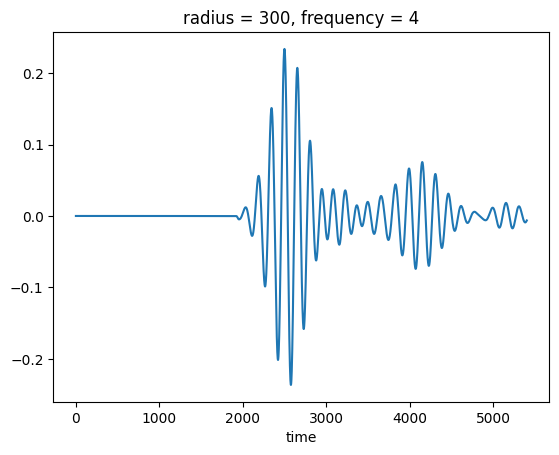

In [31]:
dataset.sel(radius=300, frequency=4).plot()
# dataset.sel(radius=300, frequency=4, time=slice(1900, 2000)).plot()
# Apparently, at timestep t=~1920 the reception begins

After some observations, we can see that all the signal, independently from the radius or the frequency, are basically absent from the initial timestep t=0 until around the timestep t=1921, where we can then see a non null response. This is expected, since there is a delay from the transmission to the reception phase. We can thus trim our dataset, removing the first 1922 timesteps values for each detected signal.

In [32]:
dataset = dataset.sel(time=slice(1922,None))
dataset['time'] = np.arange(dataset.time.size) + 1

# Store the trimmed dataset on disk
dataset.to_netcdf(os.path.join(output_folder, "orx.dataset.nc"))

print(dataset)

<xarray.DataArray (radius: 45, frequency: 10, time: 3480)> Size: 13MB
array([[[-0.00020302195826056406, -0.00022180541776444396,
         -0.0002463990514003049 , ..., -0.00038525801209138223,
         -0.0003741656940637036 , -0.0003629811204426778 ],
        [-0.00004884562617855439, -0.00008080218434218391,
         -0.00012253626571729557, ..., -0.005633510099092094  ,
         -0.005441006909692445  , -0.005246341058719355  ],
        [-0.00007202926943391269, -0.0001180118867845077 ,
         -0.00017790992891338517, ..., -0.0005062352305876322 ,
         -0.00046680125572221974, -0.00042773735495343934],
        ...,
        [-0.00018928731540280924, -0.0002995380208951935 ,
         -0.00044008282516609957, ..., -0.015102345678165575  ,
         -0.015125764117725243  , -0.015052002580451942  ],
        [-0.00021390803538738016, -0.0003349224777982374 ,
         -0.00048807531156104176, ...,  0.00046560905523276044,
         -0.0008665463177428923 , -0.0021940721823597797 ],
  

We can now plot the same signal as before, just as a visualization.

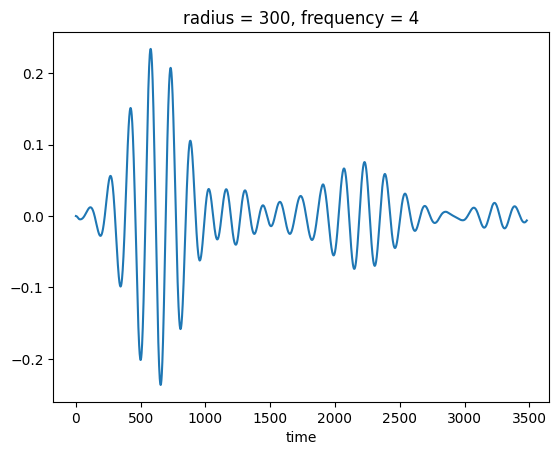

In [33]:
dataset.sel(radius=300, frequency=4).plot()

In order to obtain a single vectorized knowledge base, we have to support a considerable amount of superpositions. This means that the capacity of our knowledge base must have dimensionality high enough to tolerate heavy noise residuals. Unfortunately, the trimmed dataset has signals having 3480 components, and this is not enough in case we want to obtain a single, unique knowledge base. Ideally, we should target for x4-x6 the trimmed signals size. We can accomplish our target by the means of an interpolative expansion procedure, like the one below.

<xarray.DataArray (radius: 45, frequency: 10, time: 20880)> Size: 75MB
array([[[-0.00020302195826056406, -0.0002057609639977043 ,
         -0.00020865442294999   , ..., -0.0003667166934059245 ,
         -0.00036484981749097703, -0.0003629811204426778 ],
        [-0.00004884562617855439, -0.00005351441108523964,
         -0.00005844221326947731, ..., -0.0053114477465146725 ,
         -0.005278923177470752  , -0.005246341058719355  ],
        [-0.00007202926943391269, -0.00007875565991392074,
         -0.00008585170740399381, ..., -0.0004407131039003704 ,
         -0.0004342198448191962 , -0.00042773735495343934],
        ...,
        [-0.00018928731540280924, -0.0002055964122513767 ,
         -0.00022272385110276859, ..., -0.015087387606724605  ,
         -0.015071045528603732  , -0.015052002580451942  ],
        [-0.00021390803538738016, -0.00023186888561019782,
         -0.00025070676633387077, ..., -0.0017528921818411585 ,
         -0.0019736792129013553 , -0.0021940721823597797 ],
 

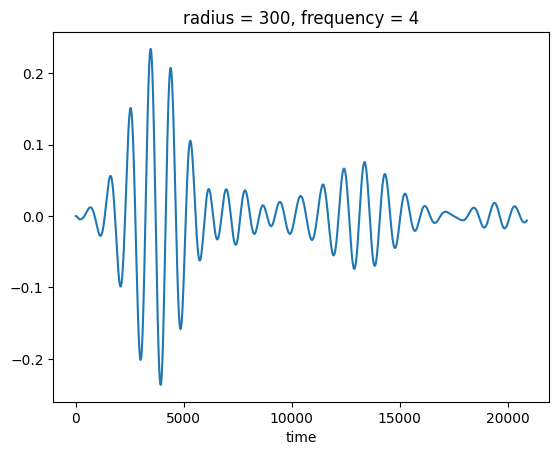

In [34]:

def interp_expand(dataset, expansion_factor=6):
    time_min = float(dataset.time.min())
    time_max = float(dataset.time.max())
    expanded_time = np.linspace(time_min, time_max, int(len(dataset.time) * expansion_factor))
    augmented_dataset = dataset.interp(time=expanded_time, method="cubic")
    augmented_dataset['time'] = np.arange(augmented_dataset.time.size) + 1
    return augmented_dataset

augmented_dataset = interp_expand(dataset, expansion_factor=6)
augmented_dataset.sel(radius=300, frequency=4).plot()
augmented_dataset.to_netcdf(os.path.join(output_folder, "aug.dataset.nc"))
print(augmented_dataset)

Let's test the package xrft, which is integrated to work with xarray and dask dataframes.

In [35]:
fft_dataset = xrft.fft(
    augmented_dataset,
    dim='time',           # dimension to transform
    shift=False,          # no shift of zero-frequency component to center
    real_transform=True   # optimized real‑to‑complex transform
)

# Rename the default xrft coordinate 'freq_*' to custom coordinate identifier
fft_dataset = fft_dataset.rename({'freq_time': 'spectrum'})

# Inspect resulting coordinates
print(fft_dataset.coords)

# Simple test: if we select an arbitrary frequency, independently from the radius, we should get a single spike, since the signal varies only its amplitude, not its frequency response. Let's make a test to verify it.
fft_test = np.abs(fft_dataset.sel(radius=300, frequency=6))
# fft_test.plot(x="spectrum")


Coordinates:
  * radius     (radius) int64 360B 10 20 30 40 50 60 ... 400 410 420 430 440 450
  * frequency  (frequency) int64 80B 1 2 3 4 5 6 7 8 9 10
  * spectrum   (spectrum) float64 167kB 0.0 4.789e-05 ... -9.579e-05 -4.789e-05


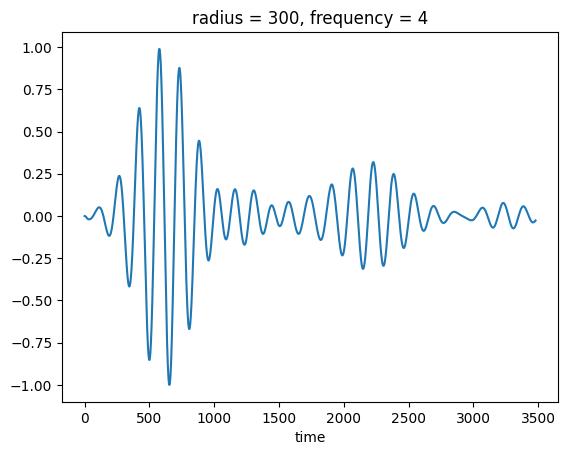

In [47]:
normalized_augmented_dataset = augmented_dataset / np.abs(augmented_dataset).max(dim="time")
normalized_augmented_dataset.to_netcdf(os.path.join(output_folder, "nrm.aug.dataset.nc"))
normalized_dataset = dataset / np.abs(dataset).max(dim="time")
normalized_dataset.to_netcdf(os.path.join(output_folder, "nrm.orx.dataset.nc"))
normalized_dataset.sel(radius=300, frequency=4).plot()
